In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.getcwd()

'/data/aqvs/notebooks'

In [3]:
import sys, glob, shutil
os.chdir(os.path.dirname(os.getcwd()))
os.getcwd()

'/data/aqvs'

#### Adding "src/networks" folder in path, to enable in-line imports for the network files using importlib

In [4]:
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
sys.path.append(os.path.abspath('./src/networks'))

#### To handel OOM errors

In [5]:
import tensorflow as tf
from keras import backend as K
import keras.backend.tensorflow_backend as ktf
def get_session():
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction= 0.2,
                                allow_growth=True)
    return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
ktf.set_session(get_session())

Using TensorFlow backend.


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam, RMSprop

In [7]:
from config import objd as config
from src.utils.preprocessing import parse_annotation

In [8]:
from src.training.datagenerator import ObjectDataGenerator as DataGenerator

In [9]:
from src.networks.yolo import Yolo
from src.networks.feature_extractors import get_feature_extractor

In [10]:
from src.training.keras_callbacks import get_callbacks
from src.evaluation.evaluate import evaluate

### Parse Config

In [11]:
backend = config['model']['backend']
input_size = config['model']['input_size']
labels = config['model']['labels']
max_box_per_image = config['model']['max_box_per_image']
anchors = config['model']['anchors']

train_times = config['train']['train_times']

nb_epochs = config['train']['nb_epochs']
learning_rate = config['train']['learning_rate'] 
batch_size = config['train']['batch_size']
warmup_epochs = config['train']['warmup_epochs']

object_scale = config['train']['object_scale']
no_object_scale = config['train']['no_object_scale']
coord_scale = config['train']['coord_scale']
class_scale = config['train']['class_scale']

labels   = list(labels)
nb_class = len(labels)
nb_box   = len(anchors)//2
class_wt = np.ones(nb_class, dtype='float32')

valid_times = 1

### Parse Annotations

In [12]:
# parse annotations of the training set
train_imgs, train_labels = parse_annotation(config['train']['train_annot_folder'], 
                                            config['train']['train_image_folder'], 
                                            config['model']['labels'])
train_labels, train_imgs 

({'crack': 103, 'wrinkle': 56},
 [{'object': [{'name': 'crack',
     'xmin': 1461,
     'ymin': 2044,
     'xmax': 2386,
     'ymax': 2707},
    {'name': 'wrinkle',
     'xmin': 1108,
     'ymin': 1227,
     'xmax': 1508,
     'ymax': 1674}],
   'filename': 'data/images/IMG20180905143750.jpg',
   'width': 4160,
   'height': 3120},
  {'object': [{'name': 'crack',
     'xmin': 588,
     'ymin': 1478,
     'xmax': 859,
     'ymax': 2111},
    {'name': 'wrinkle',
     'xmin': 1422,
     'ymin': 1113,
     'xmax': 1946,
     'ymax': 1437}],
   'filename': 'data/images/IMG20180905143945.jpg',
   'width': 3120,
   'height': 4160},
  {'object': [{'name': 'crack',
     'xmin': 530,
     'ymin': 1386,
     'xmax': 1088,
     'ymax': 1740}],
   'filename': 'data/images/IMG20180905144032.jpg',
   'width': 3120,
   'height': 4160},
  {'object': [{'name': 'crack',
     'xmin': 755,
     'ymin': 1378,
     'xmax': 930,
     'ymax': 1524}],
   'filename': 'data/images/IMG20180905144103.jpg',
   'width

### Prepare training and validation data

In [13]:
train_valid_split = int(0.8*len(train_imgs))
np.random.shuffle(train_imgs)
valid_imgs = train_imgs[train_valid_split:]
train_imgs = train_imgs[:train_valid_split]

### Import base feature extractor

In [15]:
feature_extractor, grid_h, grid_w = get_feature_extractor(backend, input_size)

Output shape for the feature extractor is: (9, 9)


### Initialise DataGenerator

In [16]:
generator_config = {
    'IMAGE_H'         : input_size,
    'IMAGE_W'         : input_size,
    'GRID_H'          : grid_h,
    'GRID_W'          : grid_w,
    'BOX'             : nb_box,
    'LABELS'          : labels,
    'CLASS'           : len(labels),
    'ANCHORS'         : anchors,
    'BATCH_SIZE'      : batch_size,
    'TRUE_BOX_BUFFER' : max_box_per_image,
}

In [17]:
train_generator = DataGenerator(train_imgs, generator_config, norm=feature_extractor.normalize)
valid_generator = DataGenerator(valid_imgs, generator_config, norm=feature_extractor.normalize, jitter=False)

### Testing datagenerator (optional)

In [ ]:
[x_batch, b_batch], y_batch = train_generator.__getitem__(1)

In [ ]:
x_batch.shape, b_batch.shape, y_batch.shape

## Prediction

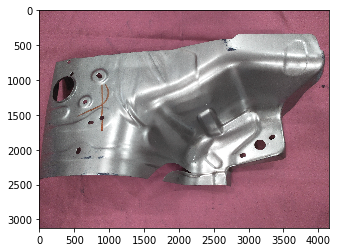

In [18]:
image_path = "data/images/IMG20180905143750.jpg"
image = cv2.imread(image_path)
plt.imshow(image)

In [19]:
#! /usr/bin/env python
import cv2
import numpy as np
from keras.models import load_model

from config import infer as config
from src.utils.utils import decode_netout, draw_boxes
from src.networks.feature_extractors import get_feature_extractor

In [20]:
#model_path = config["model_path"]
model_path = "data/yolo_t1/checkpoint-08-0.36.h5"

In [21]:
backend = config['backend']
input_size = config["input_size"]
max_box_per_image = config["max_box_per_image"]
anchors = config["anchors"]
labels = config["labels"]        
nb_class = len(labels)
model = load_model(model_path, compile=False)
feature_extractor, grid_h, grid_w = get_feature_extractor(backend, input_size)
normalize = feature_extractor.normalize

Output shape for the feature extractor is: (9, 9)


In [22]:
image_h, image_w, _ = image.shape
image = cv2.resize(image, (input_size, input_size))
image = normalize(image)
    
input_image = image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)
dummy_array = np.zeros((1,1,1,1,max_box_per_image,4))

In [24]:
x = model.predict([input_image, dummy_array])

In [26]:
x.shape

(1, 9, 9, 7, 7)

In [ ]:
netout = model.predict([input_image, dummy_array])[0]    
netout

In [ ]:
boxes  = decode_netout(netout, anchors, nb_class)

In [ ]:
image = draw_boxes(image, boxes, labels)
plt.imshow(image)

### Evaluate model

In [ ]:
average_precisions = evaluate(valid_generator)

In [ ]:
# print evaluation
for label, average_precision in average_precisions.items():
    print(labels[label], '{:.4f}'.format(average_precision))
print('mAP: {:.4f}'.format(sum(average_precisions.values()) / len(average_precisions)))